In [2]:
import data2D as data_import
import os
import matplotlib.pyplot as plt
import numpy as np
from grid import Grid
import scipy.stats as stats

D = 1e-8
N = 16
Q = 1e-19
M = 1e-27

plt.rcParams.update({'font.size': 20})
plt.rc('figure', figsize=(20, 10))


In [3]:
# 3.2 pico seconds for particle to travel L
def exec(method="Verlet",dt=1e-13, dt2=1e-12, tf=1, v=5e3, r=0):

    command = f"java -cp target/SimulacionTemporal-1.0-SNAPSHOT.jar \
                -Ddt={dt} -Ddt2={dt2} -Dtf={tf} \
                -Dv={v} -Dr={r} \
                -Dmethod={method} \
                ElectricFieldSystem"
    proc = os.popen(command)
    escaped = proc.readlines()[0]
    proc.close()
    data = data_import.Data("ElectricField.txt")
    return data, int(escaped)


In [4]:
def calculate_kinetic_energy(vx,vy,m):
    return 0.5*m*(vx**2 + vy**2)

Initial Energy 1.25e-18


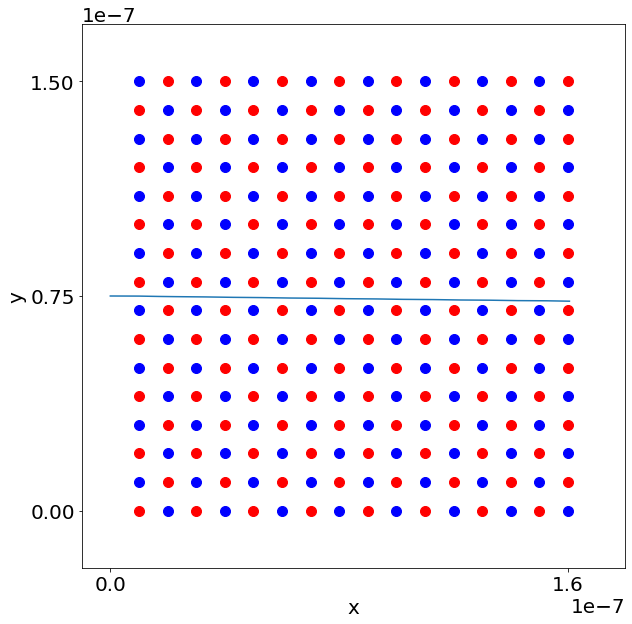

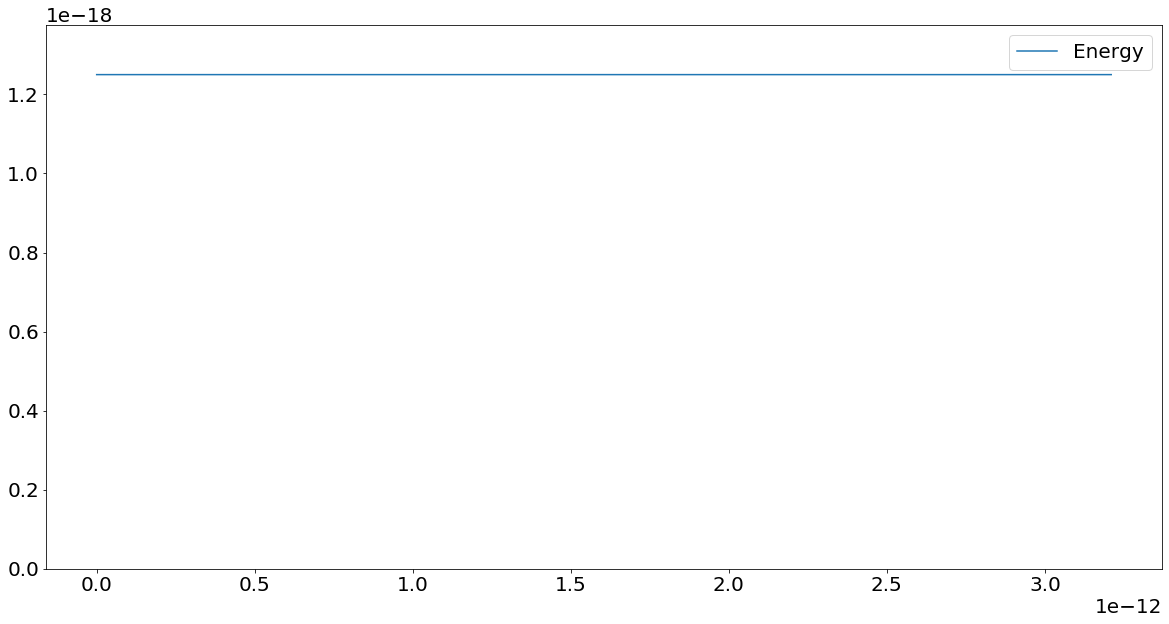

In [5]:
X = []
Y = []
E = []
T = []

grid = Grid(N, D, Q)
V = 5e4
r=0
data, escaped = exec(method="Gear",r=r, dt=1e-14, dt2=1e-14, v=V)
EU = [grid.calculate_energy(0, (N-1)*D/2 + r*D, Q)]
EK = [calculate_kinetic_energy(V,0,M)]
E =  [EU[0] + EK[0]]
T.append(0)
X.append(0)
Y.append((N-1)*D/2 + r*D)
print("Initial Energy", E[0])
for t, x, y, vx, vy in data:
    T.append(t)
    X.append(x)
    Y.append(y)
    EU.append(grid.calculate_energy(x, y, Q))
    EK.append(calculate_kinetic_energy(vx, vy, M))
    E.append(EU[-1] + EK[-1])


plt.figure("Trajectory")
grid.plot()
plt.plot(X, Y, "-", markersize=1)
plt.xticks([0, N*D])
plt.yticks([0, (N-1)*D/2, N*D - D])
plt.ylim(-2*D, N*D + D)
plt.xlim(-D, N*D + 2*D)
plt.gca().set_aspect('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

plt.figure("Energy")

plt.plot(T, E, label="Energy")
#plt.plot(T, EU, label="Potential")
#plt.plot(T, EK, label="Kinetic")
#plt.yscale("log")
#plt.plot(T, [E[0]]*len(T))
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useOffset=False)
plt.ylim(0, max(E)*1.1)
plt.legend()
plt.show()


# 2.1

In [ ]:
Y = np.linspace(-1, 1, 5)

V = 5e4

#dts = np.logspace(-17, -14, 7)
dts = [1e-17, 5e-17, 1e-16, 5e-16, 1e-15,5e-15,1e-14]

dt2 = max(dts)

means = []
errors = []

for dt in dts:

    mean = []
    for y in Y:
        Ei = grid.calculate_energy(0, (N-1)*D/2 + y*D, Q) + calculate_kinetic_energy(0, V, M)
        data, escaped = exec(method="Gear",dt=dt, dt2=dt2, v=V, r=y)

        for t, x, y, vx, vy in data:
            pass

        Ef = grid.calculate_energy(x, y, Q) + calculate_kinetic_energy(vx, vy, M)
        mean.append(np.abs(Ef/Ei - 1))

    error = np.std(mean)/np.sqrt(len(mean))
    mean = np.mean(mean)

    means.append(mean)
    errors.append(error)


plt.errorbar(dts, means, yerr=errors, fmt='o')

plt.xlabel("DT")
plt.ylabel("Conservation")
plt.yscale("log")
plt.xscale("log")
plt.show()


# 2.2

In [52]:
V = np.linspace(5e3, 5e4, 5)

Y = np.linspace(-1, 1, 40)

dt = 1e-15
dt2 = 1e-14

dataset  = {}

for v in V:

    dataset[v] = {}
    
    escaped_sum = [0, 0, 0, 0, 0]
    for y in Y:
        dataset[v][y] = {}
        data, escaped = exec(method="Gear",dt=dt, dt2=dt2, tf=1e12, v=v, r=y)

        dataset[v][y]["escaped"] = escaped

        long = 0
        xv = 0
        for t, x, _,_,_ in data:
            long += np.abs(x-xv)
            xv = x
       
        dataset[v][y]["long"] = long




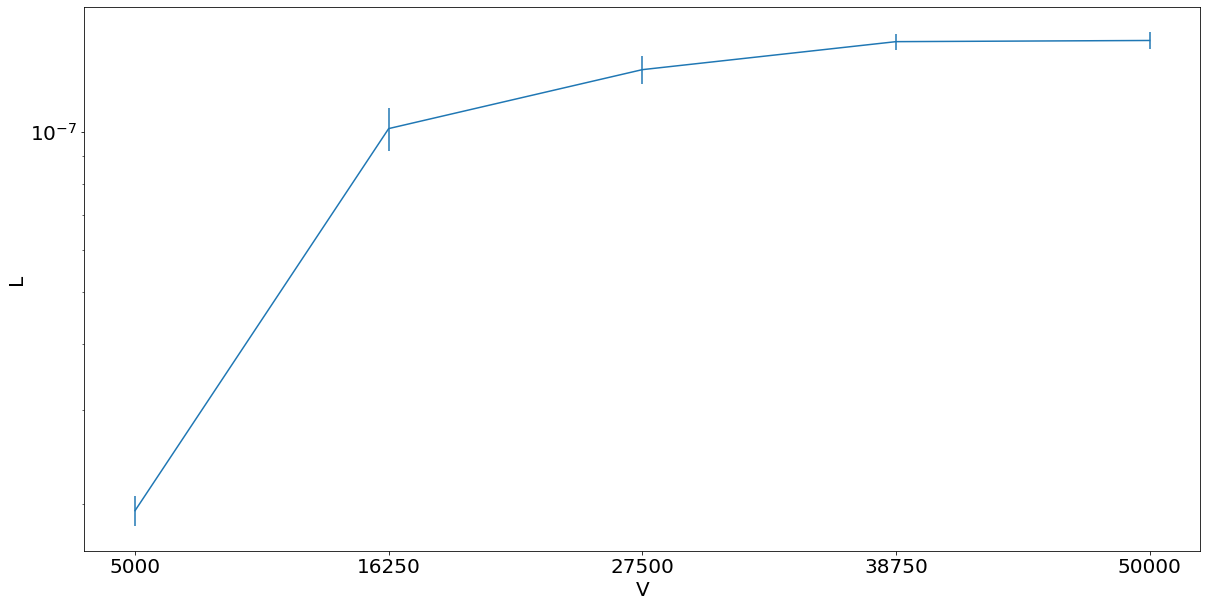

In [53]:
means = []
errors = []
for v, arr in dataset.items():
    L = [ m["long"] for y,m in arr.items()]
    means.append(np.mean(L))
    errors.append(np.std(L)/np.sqrt(len(L)))


plt.figure("Longitud vs Velocidad")
plt.errorbar(V, means, yerr=errors)
plt.xticks(V)
plt.yscale("log")
plt.xlabel("V")
plt.ylabel("L")

plt.show()



# 2.3

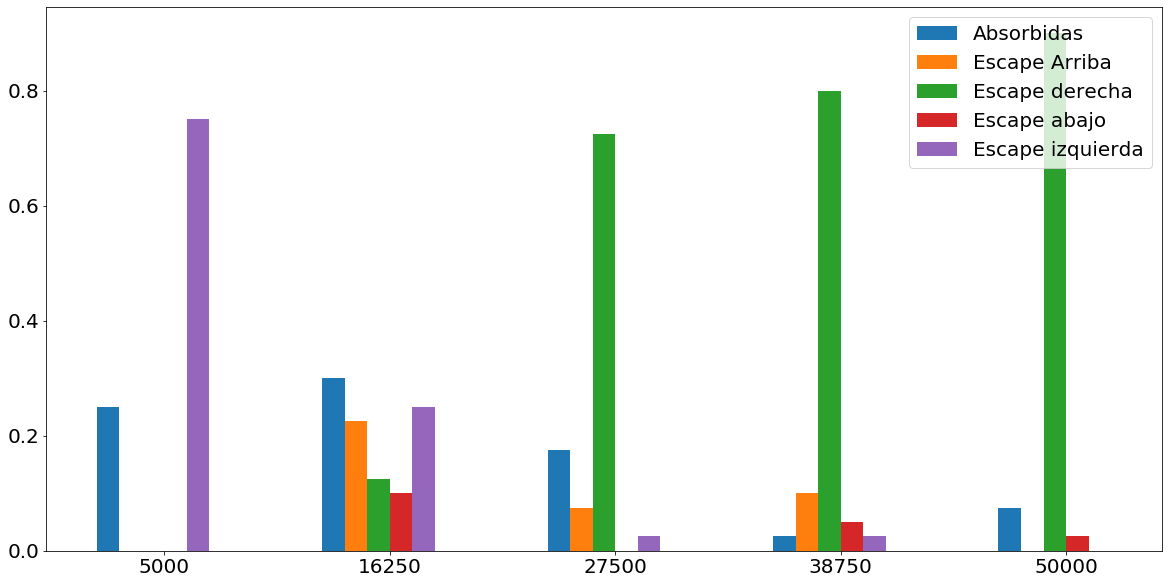

In [54]:
labels = ["Absorbidas", "Escape Arriba", "Escape derecha", "Escape abajo", "Escape izquierda"]


escapes = {}


for v, dic in dataset.items():
    escapes[v] = np.zeros(len(labels))


    for y, m in dic.items():
        index = m["escaped"]
        escapes[v][index] += 1
    
    escapes[v]/=len(Y)


plt.figure("Escapadas vs V")
x = np.arange(len(labels))
width =( V[1]-V[0] )/ 10
for i, label in enumerate(labels):
    
    arr = [ v[i] for k,v in escapes.items()]
    plt.bar(V+i*width - width*len(labels)/2,arr, width=width, label = label)

plt.legend()
plt.xticks(V)
plt.show()

## 2.4

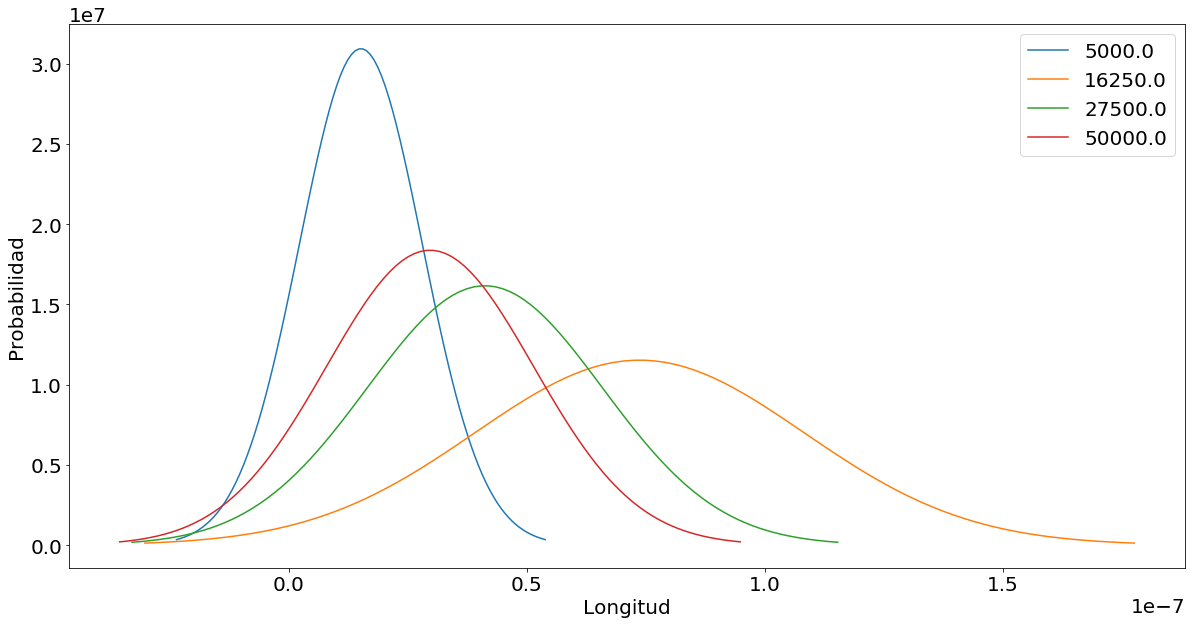

In [56]:

longituds = {}

for v, dic in dataset.items():
    arr = []
    for y, m in dic.items():
        if m["escaped"] == 0:
            arr.append(m["long"])
        
    if arr:
        longituds[v] = arr

means = []
stdevs = []
labels = []
for v, arr in longituds.items():
    stdev = np.std(arr)
    if stdev != 0:
        means.append(np.mean(arr))
        stdevs.append(np.std(arr))
        labels.append(v)


plt.figure("Gauss")

for mean,stdev,v in zip(means, stdevs, labels):
    x = np.linspace(mean -3*stdev, mean  + 3*stdev, 100)
    y = stats.norm.pdf(x, mean, stdev)
    #y/=np.max(y)
    plt.plot(x,y, label = str(v))
plt.xlabel("Longitud")
plt.ylabel("Probabilidad")
plt.legend()
plt.show()